# AEI and CPI for PL and RO

In [1]:
import pandas as pd

df = pd.read_csv("cee_pl_ro_2015_2022_dataset.csv", sep=";", skiprows=1, engine="python")

df.head(3)

,event_id,country,date,month,family,initiator,target_type,target_name,law_or_decision_id,description_short,outcome,severity,politicisation_flag,council_selection_rule,veto_align_gov_president,veto_align_gov_topcourt,eu_pressure,source_url,source_citation,notes
0,PL-2015-12-02-SEJM-5JUDGES,Poland,2015-12-02,2015-12,institutional_change,parliament,institution,Constitutional Tribunal composition,Sejm election of five CT judges,Sejm elects five CT judges replacing those cho...,approved,2,yes,peer_elected,aligned,contested,none,https://www.reuters.com/article/us-poland-cons...,Reuters (9 Dec 2015) context on appointments,NaN
1,PL-2015-12-03-MIDNIGHT-OATH,Poland,2015-12-03,2015-12,institutional_change,president,institution,Constitutional Tribunal composition,Presidential oath for five CT judges,President Duda swears in five CT judges in ove...,approved,2,yes,peer_elected,aligned,contested,none,https://www.reuters.com/article/markets/tussle...,Reuters (3 Dec 2015) midnight swearing,NaN
2,PL-2015-12-22-CT-LAW,Poland,2015-12-22,2015-12,institutional_change,parliament,institution,Constitutional Tribunal procedure,Act of 22 Dec 2015 amending CT law,"Act raises quorums/majorities, constraining CT...",approved,3,yes,peer_elected,aligned,contested,none,https://www.theguardian.com/world/2015/dec/23/...,The Guardian (23 Dec 2015) on CT law,NaN


In [2]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")


df["month"] = pd.to_datetime(df["month"].astype(str) + "-01", errors="coerce").dt.to_period("M").astype(str)


for col in ["family", "politicisation_flag", "outcome", "country"]:
    df[col] = df[col].astype(str).str.strip().str.lower()


df["severity"] = pd.to_numeric(df["severity"], errors="coerce").fillna(0).astype(int)


print("Countries:", df["country"].unique())
print("Family:", df["family"].unique())
print("Outcome sample:", df["outcome"].unique()[:10])
df[["severity"]].describe()


Countries: ['poland' 'romania']
Family: ['institutional_change' 'constraint_event' 'appointment_discipline']
Outcome sample: ['approved' 'blocked' 'soft_pressure' 'investigation_opened'
 'partially_blocked' 'reversed' 'judgment']


,severity
count,163.000000
mean,0.993865
std,0.965433
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,3.000000


## AEI

In [3]:
aei = (
    df[
        df["family"].isin(["institutional_change", "appointment_discipline"])
        & (df["politicisation_flag"] == "yes")
    ]
    .groupby(["country", "month"], as_index=False)["severity"]
    .sum()
    .rename(columns={"severity": "AEI"})
)

aei.head()


,country,month,AEI
0,poland,2015-12,7
1,poland,2016-12,2
2,poland,2017-07,3
3,poland,2017-08,1
4,poland,2017-09,1


## CPI

In [4]:
cpi = (
    df[
        (df["family"] == "constraint_event")
        | (df["outcome"].isin(["blocked", "partially_blocked", "reversed"]))
    ]
    .groupby(["country", "month"], as_index=False)["severity"]
    .sum()
    .rename(columns={"severity": "CPI"})
)

cpi.head()


,country,month,CPI
0,poland,2016-03,2
1,poland,2016-07,1
2,poland,2017-07,2
3,poland,2017-12,2
4,poland,2018-07,1


## Merging

In [5]:
indices = aei.merge(cpi, on=["country","month"], how="outer").fillna(0)
indices["month_dt"] = pd.to_datetime(indices["month"] + "-01")
indices = indices.sort_values(["country","month_dt"]).reset_index(drop=True)

indices.head(10)


,country,month,AEI,CPI,month_dt
0,poland,2015-12,7.0,0.0,2015-12-01
1,poland,2016-03,0.0,2.0,2016-03-01
2,poland,2016-07,0.0,1.0,2016-07-01
3,poland,2016-12,2.0,0.0,2016-12-01
4,poland,2017-07,3.0,2.0,2017-07-01
5,poland,2017-08,1.0,0.0,2017-08-01
6,poland,2017-09,1.0,0.0,2017-09-01
7,poland,2017-10,1.0,0.0,2017-10-01
8,poland,2017-11,1.0,0.0,2017-11-01
9,poland,2017-12,4.0,2.0,2017-12-01


## Output

In [6]:
indices.to_csv("indices_by_country_month.csv", index=False)

yearly = (
    indices.assign(year=indices["month_dt"].dt.year)
           .groupby(["country","year"], as_index=False)[["AEI","CPI"]]
           .mean()
           .rename(columns={"AEI":"AEI_mean","CPI":"CPI_mean"})
)
yearly.to_csv("aei_cpi_summary_by_year.csv", index=False)

yearly


,country,year,AEI_mean,CPI_mean
0,poland,2015,7.000000,0.000000
1,poland,2016,0.666667,1.000000
2,poland,2017,1.833333,0.666667
3,poland,2018,1.666667,0.416667
4,poland,2019,0.250000,0.416667
5,poland,2020,0.000000,0.583333
6,poland,2021,0.250000,1.083333
7,poland,2022,0.000000,2.000000
8,romania,2017,1.000000,0.000000
9,romania,2018,3.000000,0.333333


## AEI CPI Plots PL and RO

### AEI and CPI PL

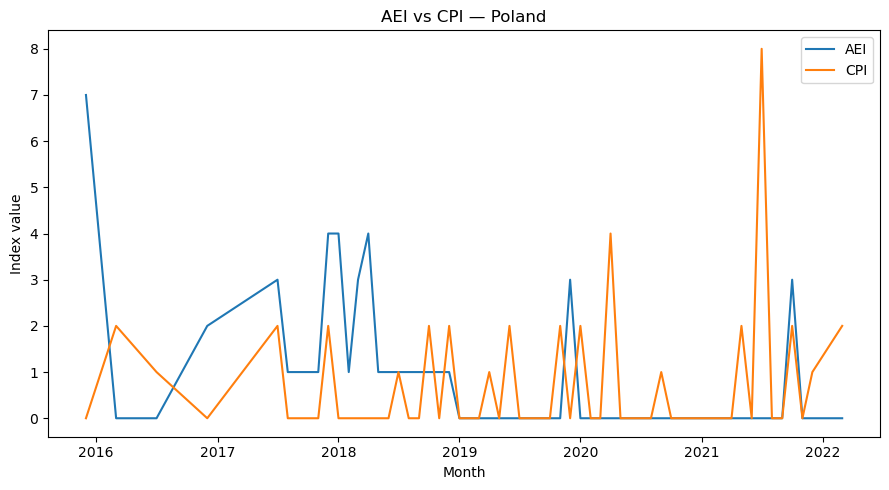

In [8]:
import matplotlib.pyplot as plt

sub = indices[indices["country"]=="poland"]

plt.figure(figsize=(9,5))
plt.plot(sub["month_dt"], sub["AEI"], label="AEI")
plt.plot(sub["month_dt"], sub["CPI"], label="CPI")
plt.title("AEI vs CPI — Poland")
plt.xlabel("Month")
plt.ylabel("Index value")
plt.legend()
plt.tight_layout()
plt.savefig("fig_aei_cpi_poland.png", dpi=200, bbox_inches="tight")
plt.show()


### AEI and CPI RO

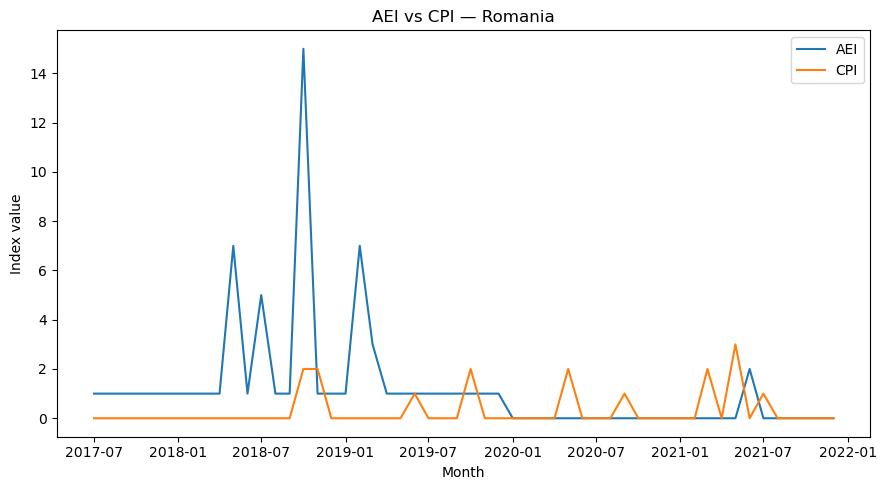

In [9]:
sub = indices[indices["country"]=="romania"]

plt.figure(figsize=(9,5))
plt.plot(sub["month_dt"], sub["AEI"], label="AEI")
plt.plot(sub["month_dt"], sub["CPI"], label="CPI")
plt.title("AEI vs CPI — Romania")
plt.xlabel("Month")
plt.ylabel("Index value")
plt.legend()
plt.tight_layout()
plt.savefig("fig_aei_cpi_romania.png", dpi=200, bbox_inches="tight")
plt.show()


### Combined Plots PL RO

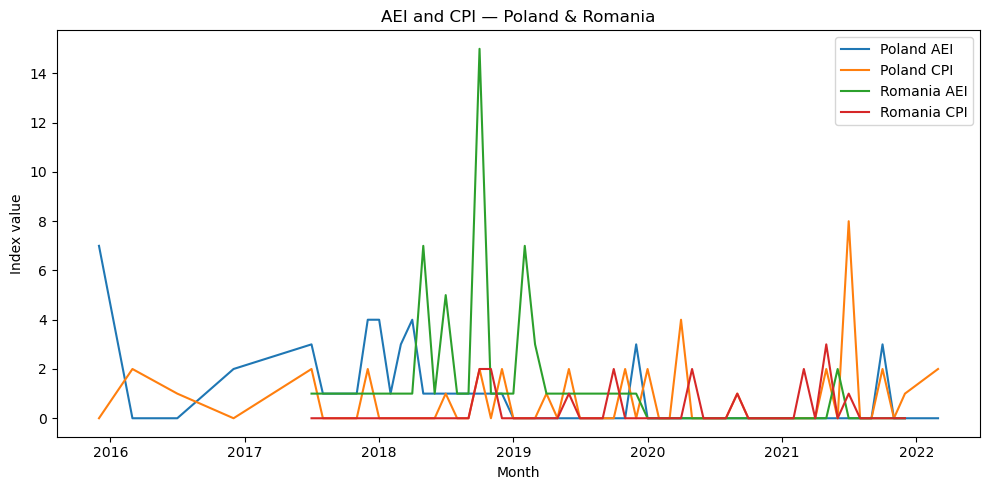

In [10]:
plt.figure(figsize=(10,5))
for country in indices["country"].unique():
    sub = indices[indices["country"]==country].sort_values("month_dt")
    plt.plot(sub["month_dt"], sub["AEI"], label=f"{country.title()} AEI")
    plt.plot(sub["month_dt"], sub["CPI"], label=f"{country.title()} CPI")

plt.title("AEI and CPI — Poland & Romania")
plt.xlabel("Month")
plt.ylabel("Index value")
plt.legend()
plt.tight_layout()
plt.savefig("fig_aei_cpi_both.png", dpi=200, bbox_inches="tight")
plt.show()


## Misc

In [12]:
print("Events per country:", df["country"].value_counts().to_dict())
print("Politicised events (yes):", (df["politicisation_flag"]=="yes").sum())
print("Constraint events:", (df["family"]=="constraint_event").sum())
print("Blocked/reversed:", df["outcome"].isin(["blocked","partially_blocked","reversed"]).sum())


Events per country: {'poland': 88, 'romania': 75}
Politicised events (yes): 68
Constraint events: 94
Blocked/reversed: 11
